<a href="https://colab.research.google.com/github/ydebessu/DataScienceBlog/blob/main/dudl_ffnmilestone_project2_yd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD
from torch.nn import MSELoss

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Plotting
import matplotlib.pyplot as plt

# Random integer generator
import numpy as np
import pandas as pd

**Data download**

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data -O heart.csv

--2025-10-19 19:40:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘heart.csv’

heart.csv               [ <=>                ]  18.03K  --.-KB/s    in 0.1s    

2025-10-19 19:40:47 (120 KB/s) - ‘heart.csv’ saved [18461]



In [3]:
# Define the column names
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

# Load the data into a pandas DataFrame, specifying the column names and handling missing values
heart_df = pd.read_csv('heart.csv', names=column_names, na_values='?')

# Display the first few rows and the data types
display(heart_df.head())
display(heart_df.info())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


None

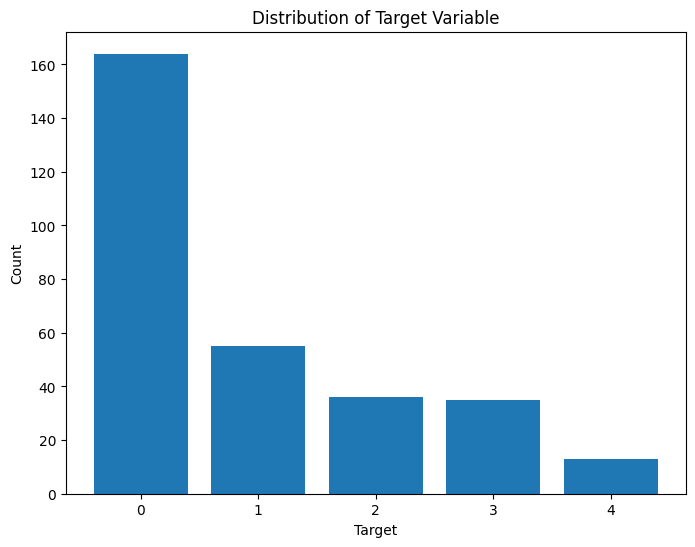

In [4]:
# Draw a bar graph for the 'target' column
target_counts = heart_df['target'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(target_counts.index, target_counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.xticks(target_counts.index)
plt.show()

In [9]:
initial_rows = len(heart_df)
heart_df.dropna(inplace=True)
remaining_rows = len(heart_df)

print(f"Number of rows before dropping NaNs: {initial_rows}")
print(f"Number of rows after dropping NaNs: {remaining_rows}")

Number of rows before dropping NaNs: 303
Number of rows after dropping NaNs: 297


**Data Preparation**

**Define Model**

**Train Model**